In [ ]:
import sys
import os
if os.getcwd().endswith('notebooks'):
    os.chdir("..")
print(os.getcwd())

## Imports

In [ ]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import clear_output

from pydub import AudioSegment
import librosa
import librosa.display

import detect_who_is_talking.data_preparation as dp
import detect_who_is_talking.model_creation as mc

## Functions

### General

In [3]:
def split_and_get_audio_features(long_audio_path, temp_short_audio_folder, sec_per_split):
    features = []
    filename = os.path.basename(long_audio_path)
    audio = AudioSegment.from_wav(long_audio_path)
    total_seconds = math.ceil(audio.duration_seconds)
    print(total_seconds)
    for i in range(0, total_seconds, sec_per_split):
        split_filename = str(i) + "_" + filename
        from_sec = i
        to_sec = i + sec_per_split
        t1 = from_sec * 1000
        t2 = to_sec * 1000
        split_audio = audio[t1:t2]
        new_fpath = os.path.join(temp_short_audio_folder, split_filename)
        split_audio.export(new_fpath, format="wav")
        data = dp.features_extractor(new_fpath)
        features.append(data)
        os.remove(new_fpath)
        print(f"{from_sec}/{total_seconds} Done")
        if i % 100 == 0:
            clear_output()
        if i == total_seconds - sec_per_split:
            print("All split successfully")
    return features, total_seconds

### For data

In [4]:
def create_training_df_from_long_files(
    long_files_folder, 
    temp_short_audio_folder, 
    sec_per_split,
    save_df_path=None
):
    """
    Create a df with the extracted features for each split as well as its corresponding class.
    The class is determined by the name of the file. 
    :param long_files_folder: The folder that contains the long files we will split. The ones with 
        the class in the filname. 
    :param temp_short_audio_folder: The folder where we will keep the temporary file splits. The files are 
        deleted after they are used so it does not really matter. 
    :param sec_per_split: How many seconds do we want to give each split? I suggest 2 or 3 because in a 
        conversation, the person talking can change quickly so you dont want it to be too long but
        at the same time you don't want it to be too short as to not get enough features. 
    :param save_df_path: If you want to save the df as a .csv file you can put the filepath here but 
        if not, the df will not be saved
    :return: a df with the extracted audio features per split and the corresponding class
    
    NOTE: If there are multiple files for the same 'class_' make sure to differentiate them with a '_'
        ex: 'John Smith_1.wav', 'John Smith_2.wav' etc.
    """
    extracted_features = []
    dict_for_df = defaultdict(lambda: [])
    if not os.path.exists(temp_short_audio_folder):
            os.makedirs(temp_short_audio_folder)
    for filename in os.listdir(long_files_folder):
        if not filename.endswith('.wav'):
            continue
        class_ = filename.split('_')[0].replace('.wav', '')
        print(class_)
        long_audio_path = os.path.join(long_files_folder, filename)
        features, total_sec = split_and_get_audio_features(long_audio_path, temp_short_audio_folder, sec_per_split)
        dict_for_df[class_].append(features)
    os.rmdir(temp_short_audio_folder)
    df_data = pd.DataFrame(dict_for_df.items(), columns=['class', 'feature'])
    df_data = df_data.explode('feature').reset_index(drop=True)
    df_data = df_data.explode('feature').reset_index(drop=True) # explode twice because of the array of lists
    df_data = df_data[['feature', 'class']]
    if save_df_path:
        df_data.to_csv(save_df_path, index=False)
    return df_data

### For predictions

In [5]:
def prediction_per_n_second(
    long_audio_path, 
    temp_short_audio_folder, 
    sec_per_split
):
    """
    This function takes the audio of a conversation between people, splits it and predicts 
        for each split who is talking. Then places the corresponding second of the split and 
        the class predicted into a dataframe.
    :param long_audio_path: The path to the audio of the conversation we want to predict.
    :param short_audios_folder: The folder where we will store the temporary files when we split them. 
        This folder does not really matter since we will delete the split file after getting the features
    :param sec_per_split: How many seconds do we want to give each split? I suggest 2 or 3 because in a 
        conversation, the person talking can change quickly so you dont want it to be too long but
        at the same time you don't want it to be too short as to not get enough features.
    :return: A df with columns 'from_sec' and 'class' predicted
    """

    filename = os.path.basename(long_audio_path)
    if not os.path.exists(temp_short_audio_folder):
        os.makedirs(temp_short_audio_folder)
    features, total_sec = split_and_get_audio_features(long_audio_path, temp_short_audio_folder, sec_per_split)
    seconds = list(range(0, total_sec, sec_per_split))
    predict_x = model.predict(np.array(features)) 
    classes_x = np.argmax(predict_x, axis=1)
    predictions = labelencoder.inverse_transform(classes_x)
    os.rmdir(temp_short_audio_folder)
    df = pd.DataFrame(np.column_stack([seconds, predictions]), columns=['from_sec', 'class'])
    return df

# Data

## Depending what you want you can chose 1 or 2 below

### 1-Create df for training if it is not already done

In [6]:
reload(dp)
long_files_folder = os.path.join('data', 'training_podcasts')
temp_short_audio_folder = os.path.join('data', 'BillAndrew')
sec_split = 2
save_df_path = os.path.join('data', 'bill_andrew_train.csv') # If you do not want it saved, put None
#+++++++++++++++++++++++++++++++++++
df = create_training_df_from_long_files(
    long_files_folder,
    temp_short_audio_folder,
    sec_split,
    save_df_path
)

### 2-Import the data training data from csv

In [6]:
reload(dp)
csv_path = os.path.join('data', 'bill_andrew_train.csv')
df = pd.read_csv(csv_path).sample(frac=1).reset_index(drop=True)
df['feature'] = df['feature'].map(lambda x: dp.prepare_df_for_model(str(x)))
df

,feature,class
0,"[-267.50403, 120.61325, -7.410134, 34.12321, 9...",Andrew Santino
1,"[-452.878143, 102.423706, -3.94387078, 27.5198...",Bill Burr
2,"[-274.415527, 104.838676, -10.5751324, 23.6092...",Andrew Santino
3,"[-402.152802, 110.370094, -5.60972214, 33.4003...",Bill Burr
4,"[-300.76395, 93.9832, -54.022655, 24.942396, -...",Bill Burr
...,...,...
3772,"[-328.74475, 67.530731, -27.32774, 43.89048, -...",Bill Burr
3773,"[-223.19661, 123.016914, -5.380184, 19.082811,...",Andrew Santino
3774,"[-428.26306, 66.002899, 11.153426, 23.832281, ...",Bill Burr
3775,"[-383.57785, 115.741776, -15.2388105, 39.14256...",Bill Burr


In [7]:
df['class'].value_counts()

Bill Burr         2114
Andrew Santino    1663
Name: class, dtype: int64

## Balance out the Classes

In [9]:
# Say we want to remove 400 rows of 'Bill Burr' class we can do this
class_to_drop = 'Bill Burr'
n_rows_to_drop = 400
#+++++++++++++++++++++++++++++
indexes_to_drop = list(df[df['class']==class_to_drop].sample(n=n_rows_to_drop).index)
df = df.drop(index=indexes_to_drop).reset_index(drop=True)
print(df.shape)
df['class'].value_counts()

(2977, 2)


Andrew Santino    1663
Bill Burr         1314
Name: class, dtype: int64

## Split into training and test sets + get labelencoder

In [11]:
reload(mc)
X_train, X_test, y_train, y_test, labelencoder = mc.encode_and_train_test_split(df, save_encoder=False)

# Model

## Initiate the Model

In [ ]:
reload(mc)
model = mc.create_model(y_train)

## Train the model

In [13]:
reload(mc)
model = mc.compile_and_train_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    num_epochs=100,
    num_batch_size=32,
    save_model=False,
)

Epoch 1/100
75/75 [==============================] - 2s 8ms/step - loss: 12.2261 - accuracy: 0.5212 - val_loss: 0.6440 - val_accuracy: 0.6611
Epoch 2/100
75/75 [==============================] - 0s 5ms/step - loss: 3.7604 - accuracy: 0.5304 - val_loss: 0.6848 - val_accuracy: 0.5487
Epoch 3/100
75/75 [==============================] - 0s 5ms/step - loss: 1.7615 - accuracy: 0.5338 - val_loss: 0.6766 - val_accuracy: 0.6477
Epoch 4/100
75/75 [==============================] - 0s 5ms/step - loss: 1.0880 - accuracy: 0.5607 - val_loss: 0.6810 - val_accuracy: 0.5487
Epoch 5/100
75/75 [==============================] - 0s 5ms/step - loss: 0.8462 - accuracy: 0.6027 - val_loss: 0.6772 - val_accuracy: 0.5503
Epoch 6/100
75/75 [==============================] - 0s 5ms/step - loss: 0.7907 - accuracy: 0.6077 - val_loss: 0.6696 - val_accuracy: 0.5487
Epoch 7/100
75/75 [==============================] - 0s 5ms/step - loss: 0.7037 - accuracy: 0.6338 - val_loss: 0.6259 - val_accuracy: 0.5721
Epoch 8/100


Epoch 59/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0359 - accuracy: 0.9878 - val_loss: 0.0367 - val_accuracy: 0.9849
Epoch 60/100
75/75 [==============================] - 0s 4ms/step - loss: 0.0289 - accuracy: 0.9882 - val_loss: 0.0352 - val_accuracy: 0.9899
Epoch 61/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0341 - accuracy: 0.9899 - val_loss: 0.0415 - val_accuracy: 0.9866
Epoch 62/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0311 - accuracy: 0.9903 - val_loss: 0.0378 - val_accuracy: 0.9866
Epoch 63/100
75/75 [==============================] - 0s 5ms/step - loss: 0.0280 - accuracy: 0.9908 - val_loss: 0.0315 - val_accuracy: 0.9899
Epoch 64/100
75/75 [==============================] - 0s 4ms/step - loss: 0.0255 - accuracy: 0.9908 - val_loss: 0.0468 - val_accuracy: 0.9832
Epoch 65/100
75/75 [==============================] - 0s 4ms/step - loss: 0.0251 - accuracy: 0.9916 - val_loss: 0.0281 - val_accuracy: 0.9916
Epoch 

## Get the model Accuracy

In [14]:
reload(mc)
mc.get_model_accuracy(model, X_test, y_test)

0.9848993420600891

# Who is talking in a Conversation

## Create a DF with predictions of who is talking during a conversation

In [15]:
reload(mc)
convo_path = os.path.join('data', 'conversation_podcasts', 'Bill_and_Andrew.wav')
temp_folder = os.path.join('data', 'BillAndrew')
sec_split = 2
#++++++++++++++++++++++++++++++++++++
df = prediction_per_n_second(convo_path, temp_folder, sec_split)
df['from_sec'] = df['from_sec'].astype(int)

4602/4623 Done
4604/4623 Done
4606/4623 Done
4608/4623 Done
4610/4623 Done
4612/4623 Done
4614/4623 Done
4616/4623 Done
4618/4623 Done
4620/4623 Done
4622/4623 Done
73/73 [==============================] - 0s 4ms/step


In [16]:
df

,from_sec,class
0,0,Andrew Santino
1,2,Andrew Santino
2,4,Andrew Santino
3,6,Andrew Santino
4,8,Andrew Santino
...,...,...
2307,4614,Andrew Santino
2308,4616,Andrew Santino
2309,4618,Andrew Santino
2310,4620,Andrew Santino


### Save the results to a csv if we want to

In [15]:
# df.to_csv(os.path.join('results', 'bill_andrew_podcast_predict.csv'), index=False)

## View Specific time if we want

In [21]:
df[(df['from_sec']>=795) & (df['from_sec']<=808)]

,from_sec,class
398,796,Bill Burr
399,798,Bill Burr
400,800,Bill Burr
401,802,Bill Burr
402,804,Andrew Santino
403,806,Andrew Santino
404,808,Bill Burr


## Compare how often 1 person talks VS the other

In [22]:
# View the percentage that each person spoke
df['class'].value_counts(normalize=True)

Andrew Santino    0.554498
Bill Burr         0.445502
Name: class, dtype: float64

<Axes: >

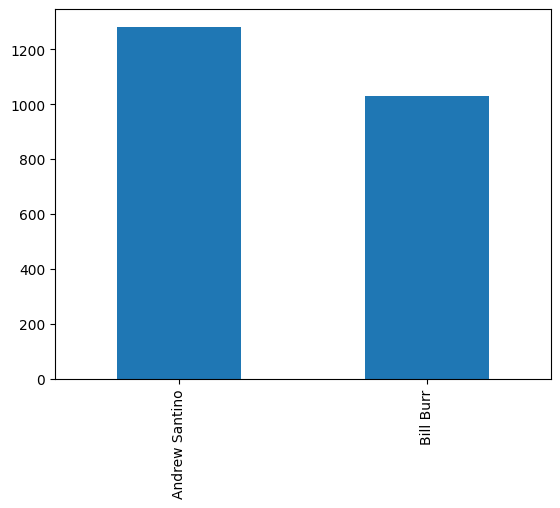

In [23]:
# View it as a graph
df['class'].value_counts().plot(kind='bar')